In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_palette('cubehelix')
pd.options.display.max_rows = 25

In [3]:
with open('pickles/may_2018_with_counts.pickle','rb') as read_file:
    may18_turnstiles = pickle.load(read_file)

## Bar plots showing total exits and entries at MTA stops in May 2018

In [4]:
#create data frams for both daily exits and entries
#Entries
may18_turnstiles_daily_entries = may18_turnstiles.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])\
.ENTRIES.first().reset_index()

may18_turnstiles_daily_entries[["PREV_DATE", "PREV_ENTRIES"]] = (may18_turnstiles_daily_entries
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .transform(lambda grp: grp.shift(1)))
def get_daily_entry_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    return counter

may18_turnstiles_daily_entries["DAILY_ENTRIES"] = may18_turnstiles_daily_entries.apply(get_daily_entry_counts, 
                                                                                       axis=1, max_counter=1000000) 
may18_turnstiles_daily_entries = may18_turnstiles_daily_entries.dropna()

In [5]:
#exits
may18_turnstiles_daily_exits = may18_turnstiles.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])\
.EXITS.first().reset_index()

may18_turnstiles_daily_exits[["PREV_DATE", "PREV_EXITS"]] = (may18_turnstiles_daily_exits
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"]
                                                       .transform(lambda grp: grp.shift(1)))
def get_daily_exit_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        return 0
    return counter
may18_turnstiles_daily_exits["DAILY_EXITS"] = may18_turnstiles_daily_exits.apply(get_daily_exit_counts, 
                                                                                 axis=1, max_counter=1000000) 

may18_turnstiles_daily_exits = may18_turnstiles_daily_exits.dropna()

In [6]:
#Create a df with a column that sums all turnstyles at a given stop
#yielding total entries per month at a given station in May 2018.
may18_entries = may18_turnstiles_daily_entries.groupby('STATION').sum().reset_index()
may18_entries.rename(columns = {'DAILY_ENTRIES':'TTL_ENTRIES_MONTH'}, inplace = True)
may18_entries.sort_values('TTL_ENTRIES_MONTH', ascending = False ).head(10)

,STATION,ENTRIES,PREV_ENTRIES,TTL_ENTRIES_MONTH
59,34 ST-PENN STA,107350374918,1.073462e+11,4481073.0
230,GRD CNTRL-42 ST,41141923989,4.114107e+10,3501329.0
57,34 ST-HERALD SQ,151184268460,1.511821e+11,3280477.0
255,JOURNAL SQUARE,255543748,2.554378e+08,2849193.0
45,23 ST,180833457802,1.808308e+11,2836696.0
14,14 ST-UNION SQ,22477160328,2.235859e+10,2617315.0
350,TIMES SQ-42 ST,157551986492,1.575511e+11,2510090.0
65,42 ST-PORT AUTH,204808623100,2.048066e+11,2505629.0
223,FULTON ST,117058994516,1.170567e+11,2283984.0
107,86 ST,65644510400,6.564955e+10,2076593.0


In [7]:
#Calculate number of entries above which represents the 95 percentile.
top_5pcnt_entries_may18 = may18_entries['TTL_ENTRIES_MONTH'].quantile(.95)

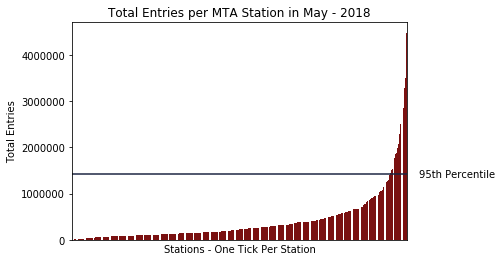

In [9]:
#To create the plots below
#Plotting total entries per station in May 18 sorted in ascending order
#shows what appears to be a Pareto distribution.
plot = sns.barplot(x = 'STATION', y = 'TTL_ENTRIES_MONTH', data = may18_entries.sort_values('TTL_ENTRIES_MONTH', ascending=True), color = 'darkred' )
plt.title('Total Entries per MTA Station in May - 2018')
plot.set(xlabel = 'Stations - One Tick Per Station', ylabel = 'Total Entries')
plot.axes.get_xaxis().set_ticks([])
plt.axhline(y = top_5pcnt_entries_may18)
plt.text(1.15, 0.3,'95th Percentile', horizontalalignment='center',
      verticalalignment='center',
      transform=plot.transAxes)
plt.savefig('presentation/figures/ttl_entries_perstation_may18.svg')

In [10]:
#Zoom in on the stations above the line on the above plot.
top_5_may18_df = may18_entries[may18_entries['TTL_ENTRIES_MONTH'] > top_5pcnt_entries_may18]

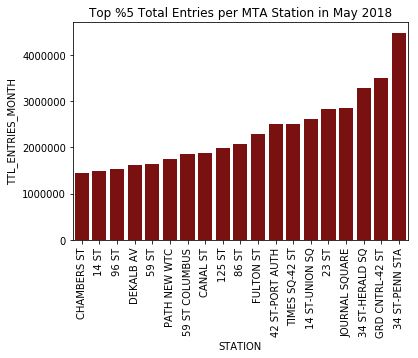

In [11]:
plot = sns.barplot(x = 'STATION', y = 'TTL_ENTRIES_MONTH', 
                   data = top_5_may18_df.sort_values('TTL_ENTRIES_MONTH'), 
                   color = 'darkred')
plt.title('Top %5 Total Entries per MTA Station in May 2018')
plt.setp(plot.get_xticklabels(), rotation=90)
plt.savefig('presentation/figures/total_entries_May18_5percent.svg')

In [12]:
#repeat the above process for exit graphs.
may18_exits = may18_turnstiles_daily_exits.groupby('STATION').sum().reset_index()
may18_exits.rename(columns = {'DAILY_EXITS':'TTL_EXITS_MONTH'}, inplace = True)
may18_exits.sort_values('TTL_EXITS_MONTH', ascending = False ).head(10)

,STATION,EXITS,PREV_EXITS,TTL_EXITS_MONTH
59,34 ST-PENN STA,79424797426,7.942232e+10,4190124.0
230,GRD CNTRL-42 ST,58382808240,5.838207e+10,3877164.0
57,34 ST-HERALD SQ,196034417452,1.960322e+11,2989272.0
350,TIMES SQ-42 ST,122877247587,1.228756e+11,2947040.0
255,JOURNAL SQUARE,217766658,2.177572e+08,2694815.0
14,14 ST-UNION SQ,8044988000,8.043095e+09,2613922.0
45,23 ST,200737617514,2.007357e+11,2040807.0
65,42 ST-PORT AUTH,167192064660,1.671903e+11,1892189.0
223,FULTON ST,117828641330,1.178268e+11,1863740.0
107,86 ST,69191000705,6.919774e+10,1738058.0


In [13]:
top_5pcnt_exits_may18 = may18_exits['TTL_EXITS_MONTH'].quantile(.95)

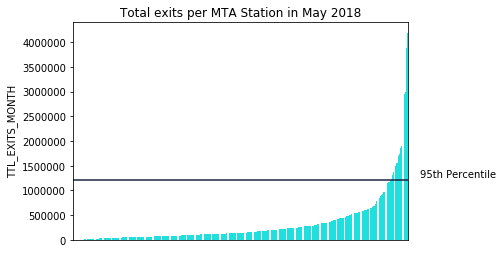

In [15]:
plot = sns.barplot(x = 'STATION', y = 'TTL_EXITS_MONTH', data = may18_exits.sort_values('TTL_EXITS_MONTH'), color='cyan')
plt.title('Total exits per MTA Station in May 2018')
plot.axes.get_xaxis().set_visible(False)
plt.axhline(y = top_5pcnt_exits_may18)
plt.text(1.15, 0.3,'95th Percentile', horizontalalignment='center',
      verticalalignment='center',
      transform=plot.transAxes)
plt.savefig("presentation/figures/total_exits_perstation_May18.svg")

In [16]:
#Like before, zoom in on the stations above the line on the above plot.
top_5_may18_df = may18_exits[may18_exits['TTL_EXITS_MONTH'] > top_5pcnt_exits_may18]

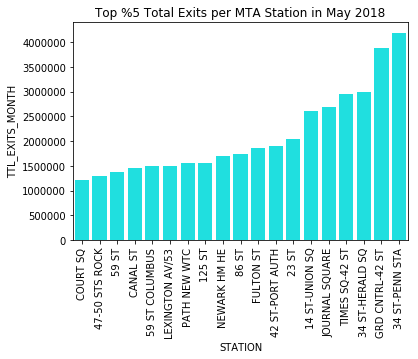

In [17]:
plot = sns.barplot(x = 'STATION', y = 'TTL_EXITS_MONTH', 
                   data = top_5_may18_df.sort_values('TTL_EXITS_MONTH'), 
                   color = 'cyan')
plt.title('Top %5 Total Exits per MTA Station in May 2018')
plt.setp(plot.get_xticklabels(), rotation=90)
plt.savefig('presentation/figures/total_exits_May18_5percent.svg')

In [18]:
may18_turnstiles_daily = may18_turnstiles.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])\
.EXITS.first().reset_index()

## Line plots showing weekly entries of top 1% busiest stations in May 2018

In [19]:
top_1pcnt_may18_exits = may18_exits['TTL_EXITS_MONTH'].quantile(.99)

In [20]:
top_1pcnt_may18_exits

2760393.4999999977

In [21]:
top_1_may18_exits = may18_exits[may18_exits['TTL_EXITS_MONTH'] > top_1pcnt_may18_exits]

In [22]:
may18_exits_df = may18_turnstiles_daily_exits.groupby(['STATION', 'DATE'])['DAILY_EXITS'].sum().reset_index()


In [23]:
top_1_may18_exits

,STATION,EXITS,PREV_EXITS,TTL_EXITS_MONTH
57,34 ST-HERALD SQ,196034417452,1.960322e+11,2989272.0
59,34 ST-PENN STA,79424797426,7.942232e+10,4190124.0
230,GRD CNTRL-42 ST,58382808240,5.838207e+10,3877164.0
350,TIMES SQ-42 ST,122877247587,1.228756e+11,2947040.0


In [24]:
top_1perc = (may18_exits_df[(may18_exits_df['STATION']=='34 ST-HERALD SQ') | 
                            (may18_exits_df['STATION']=='34 ST-PENN STA')|
                            (may18_exits_df['STATION']=='GRD CNTRL-42 ST')|
                            (may18_exits_df['STATION']=='TIMES SQ-42 ST')])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

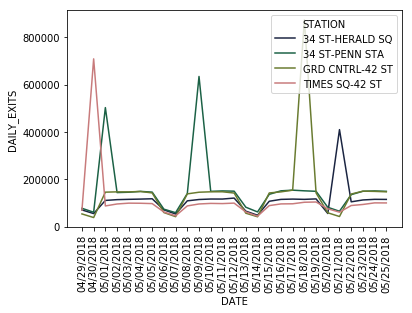

In [25]:
plot = sns.lineplot(x='DATE', y = 'DAILY_EXITS', data=top_1perc, hue='STATION')
plt.setp(plot.get_xticklabels(), rotation=90)

### Fix Outliers - i.e. take out spikes in above graph

In [26]:
#fix Time Square 4/30 outlier
top_1perc[(top_1perc["STATION"]=='TIMES SQ-42 ST')].head()


,STATION,DATE,DAILY_EXITS
9425,TIMES SQ-42 ST,04/29/2018,69211.0
9426,TIMES SQ-42 ST,04/30/2018,708722.0
9427,TIMES SQ-42 ST,05/01/2018,87038.0
9428,TIMES SQ-42 ST,05/02/2018,95355.0
9429,TIMES SQ-42 ST,05/03/2018,98829.0


In [27]:
top_1perc[(top_1perc["STATION"]=='TIMES SQ-42 ST') & (top_1perc["DATE"]=='04/30/2018')]['DAILY_EXITS']
fill_in_exits = top_1perc[(top_1perc["STATION"]=='TIMES SQ-42 ST') & (top_1perc["DATE"]=='04/29/2018')]['DAILY_EXITS']
top_1perc.at[9426, 'DAILY_EXITS'] = fill_in_exits

In [28]:
#Get rid of Grand Central abberation
top_1perc[(top_1perc["STATION"]=='GRD CNTRL-42 ST')].tail(10)

,STATION,DATE,DAILY_EXITS
6227,GRD CNTRL-42 ST,05/16/2018,146501.0
6228,GRD CNTRL-42 ST,05/17/2018,153833.0
6229,GRD CNTRL-42 ST,05/18/2018,873517.0
6230,GRD CNTRL-42 ST,05/19/2018,142024.0
6231,GRD CNTRL-42 ST,05/20/2018,58097.0
6232,GRD CNTRL-42 ST,05/21/2018,42317.0
6233,GRD CNTRL-42 ST,05/22/2018,137313.0
6234,GRD CNTRL-42 ST,05/23/2018,149542.0
6235,GRD CNTRL-42 ST,05/24/2018,148558.0
6236,GRD CNTRL-42 ST,05/25/2018,146736.0


In [29]:
top_1perc[(top_1perc["STATION"]=='GRD CNTRL-42 ST') & (top_1perc["DATE"]=='05/18/2018')]['DAILY_EXITS']
fill_in_exits = top_1perc[(top_1perc["STATION"]=='GRD CNTRL-42 ST') & (top_1perc["DATE"]=='05/17/2018')]['DAILY_EXITS']
top_1perc.at[6229, 'DAILY_EXITS'] = fill_in_exits


In [30]:
top_1perc[(top_1perc["STATION"]=='34 ST-HERALD SQ')].tail(10)

,STATION,DATE,DAILY_EXITS
1556,34 ST-HERALD SQ,05/16/2018,114760.0
1557,34 ST-HERALD SQ,05/17/2018,115984.0
1558,34 ST-HERALD SQ,05/18/2018,114873.0
1559,34 ST-HERALD SQ,05/19/2018,116751.0
1560,34 ST-HERALD SQ,05/20/2018,55166.0
1561,34 ST-HERALD SQ,05/21/2018,409605.0
1562,34 ST-HERALD SQ,05/22/2018,104413.0
1563,34 ST-HERALD SQ,05/23/2018,112324.0
1564,34 ST-HERALD SQ,05/24/2018,114990.0
1565,34 ST-HERALD SQ,05/25/2018,114647.0


In [31]:
top_1perc[(top_1perc["STATION"]=='34 ST-HERALD SQ') & (top_1perc["DATE"]=='05/21/2018')]['DAILY_EXITS']
fill_in_exits = top_1perc[(top_1perc["STATION"]=='34 ST-HERALD SQ') & (top_1perc["DATE"]=='05/20/2018')]['DAILY_EXITS']
top_1perc.at[1561, 'DAILY_EXITS'] = fill_in_exits

In [32]:
top_1perc[(top_1perc["STATION"]=='34 ST-PENN STA')].head(20)

,STATION,DATE,DAILY_EXITS
1593,34 ST-PENN STA,04/29/2018,77105.0
1594,34 ST-PENN STA,04/30/2018,60443.0
1595,34 ST-PENN STA,05/01/2018,502678.0
1596,34 ST-PENN STA,05/02/2018,143594.0
1597,34 ST-PENN STA,05/03/2018,145014.0
1598,34 ST-PENN STA,05/04/2018,148501.0
1599,34 ST-PENN STA,05/05/2018,145500.0
1600,34 ST-PENN STA,05/06/2018,73350.0
1601,34 ST-PENN STA,05/07/2018,58570.0
1602,34 ST-PENN STA,05/08/2018,139457.0


In [33]:
top_1perc[(top_1perc["STATION"]=='34 ST-PENN STA') & (top_1perc["DATE"]=='05/09/2018')]['DAILY_EXITS']
fill_in_exits = top_1perc[(top_1perc["STATION"]=='34 ST-PENN STA') & (top_1perc["DATE"]=='05/08/2018')]['DAILY_EXITS']
top_1perc.at[1603, 'DAILY_EXITS'] = fill_in_exits

top_1perc[(top_1perc["STATION"]=='34 ST-PENN STA') & (top_1perc["DATE"]=='05/01/2018')]['DAILY_EXITS']
fill_in_exits = top_1perc[(top_1perc["STATION"]=='34 ST-PENN STA') & (top_1perc["DATE"]=='04/30/2018')]['DAILY_EXITS']
top_1perc.at[1595, 'DAILY_EXITS'] = fill_in_exits


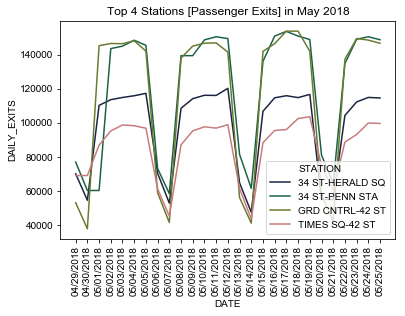

In [34]:
plot = sns.lineplot(x='DATE', y = 'DAILY_EXITS', data=top_1perc, hue='STATION')
plt.setp(plot.get_xticklabels(), rotation=90)
sns.set(rc={'figure.figsize':(15,10)})
plt.title('Top 4 Stations [Passenger Exits] in May 2018')
plt.savefig('presentation/figures/top4_month_ttlexits.svg')